In [ ]:
from Bio import SeqIO
import collections
import pandas as pd 
import re
import requests
import json
import time
import collections
import glob
import pprint
import seaborn as sns
import pylab as plt
from matplotlib.ticker import MaxNLocator
import pycountry_convert as pc
pp = pprint.PrettyPrinter()

## 1. Transform country-publication edges into country-country of institution edges

### Notes
* I am working with applicant countries now, but would probably want to look into the patent owners as well at some point
* Now I am mapping the country affiliations (for both patents and scientific articles) as one per country mentioned (even if various e.g. German universities participated) --> might still want to consider adjusting that to count all of them? --> for the patent I would run into further necessary adjustment to not double count inventors and applicants. 

In [2]:
# import the CoO dataset
df_edges_orig_pub_for_merge = pd.read_csv('../Network data/orig_pub_edges.csv', dtype = 'string')

In [3]:
## how many used sequences are there with CoO information
len(df_edges_orig_pub_for_merge)

76

In [7]:
## number of publications reporting CoO info
len(set(df_edges_orig_pub_for_merge['pubMed']))

22

In [3]:
## delete multiple sequences from one publication (not theoretically important how many sequences travelled where... )
df_edges_orig_pub_for_merge2 = df_edges_orig_pub_for_merge[['pubMed','origin']].rename(columns = {'pubMed':'pubmedID'}).drop_duplicates()

## how much information outflow is there 
len(df_edges_orig_pub_for_merge2)

23

In [36]:
df_edges_orig_pub_for_merge2

,pubmedID,origin
0,25566211,Italy
1,18582469,Japan
4,17097766,Japan
5,15808904,Japan
6,20008370,Japan
...,...,...
71,23817423,China
72,20810728,China
73,29959252,USA
74,26021931,USA


In [34]:
# what are the most listed origins here
counter = collections.Counter(df_edges_orig_pub_for_merge2['origin'])
counter.most_common()

[('Japan', 13), ('China', 4), ('USA', 3), ('Italy', 2), ('Viet Nam', 1)]

In [5]:
## how much information outflow per publication? 
counter = collections.Counter(df_edges_orig_pub_for_merge2['pubmedID'])
counter.most_common()

[('29959252', 2),
 ('25566211', 1),
 ('18582469', 1),
 ('17097766', 1),
 ('15808904', 1),
 ('20008370', 1),
 ('16364184', 1),
 ('18391543', 1),
 ('20483239', 1),
 ('15488950', 1),
 ('33401907', 1),
 ('17934781', 1),
 ('21551351', 1),
 ('17804255', 1),
 ('12647242', 1),
 ('15338081', 1),
 ('15042329', 1),
 ('27647835', 1),
 ('24040239', 1),
 ('23817423', 1),
 ('20810728', 1),
 ('26021931', 1)]

In [4]:
# open scholarly dataaset
with open(r'..\Raw data\full-data_scholarly-lens.json') as json_string:
    data = json.load(json_string)

In [ ]:
##pp.pprint(data)

In [5]:
## get number of pubmedIDs in dataset
for i in data: 
    print(i['total'])

544


In [6]:
## read the raw scholarly data and prepare for merging with CoO dataset
##look at the dictionaries: {pubmed:all the authors} --> then run a loop through it to create new lists of edges
pubmed_ids = []
lens_scholarly_id = []
#affiliations = []
#affiliations_ids = []
authors = []
#author_ids = []
affiliations_countries = []


for i in data: 
    for k, v in i.items(): 
        if k == 'data': 
            for publication in v: 
                for e in publication['external_ids']:
                    for keys, values in e.items():
                        if values == 'pmid':
                            for author in publication['authors']: 
                                # pubmedid
                                pubmed_ids.append(e['value'])
                                lens_scholarly_id.append(publication['lens_id'])
                                
                                #authors
                                author_placeholder = ''
                                if 'first_name' in author.keys():                                    
                                    author_placeholder = author['first_name']
                                    author_placeholder = author_placeholder+' '+author['last_name']
                                else: 
                                    author_placeholder = author['last_name']
                                authors.append(author_placeholder)
                                
                                ##author ids
                                #author_id_placeholder = ''
                                #if 'ids' in author.keys(): 
                                #    author_id_placeholder = author['ids']
                            
                                #author_ids.append(author_id_placeholder)
                                
                                
                                ##afilliations
                                #affiliation_placeholder = ''
                                #affiliation_ids_placeholder = ''
                                country_placeholder = ''
                                if 'affiliations' in author.keys():
                                    affiliation_placeholder = author['affiliations'][0]['name']
                                    if 'ids' in author['affiliations'][0]: 
                                        affiliation_ids_placeholder = author['affiliations'][0]['ids']
                                    
                                #countries
                                    if 'country_code' in author['affiliations'][0].keys():
                                        country_placeholder = author['affiliations'][0]['country_code']
                                    
                                #affiliations.append(affiliation_placeholder)
                                #affiliations_ids.append(affiliation_ids_placeholder)
                                affiliations_countries.append(country_placeholder)
                                

# export it as dictionary
dict_author_edges = {'pubmedID': pubmed_ids, 'lens_scholarly_id': lens_scholarly_id, 'affiliation_country' : affiliations_countries} # 'affiliations': affiliations, 'affiliation_id': affiliations_ids, 'author' : authors, 'author_ids' : author_ids,  
df_dict_author_edges = pd.DataFrame(dict_author_edges)


In [61]:
## inspect authors. this is kind of like a list of indegrees amongst authors
print(len(authors))
print(len(set(authors)))
counter=collections.Counter(authors)
counter.most_common()


3310
2423


[('Sydney Brenner', 45),
 ('Byrappa Venkatesh', 31),
 ('Greg Elgar', 28),
 ('Yuzuru Suzuki', 16),
 ('Tohru Suzuki', 16),
 ('Hiroaki Suetake', 15),
 ('Jian-Zhong Shao', 12),
 ('Shigehisa Hirose', 12),
 ('Melody S. Clark', 11),
 ('Akira Kato', 11),
 ('Jean Weissenbach', 10),
 ('Yoshizumi Ishino', 10),
 ('Michael W. W. Adams', 10),
 ('Kiyoshi Kikuchi', 10),
 ('Wolfgang Liebl', 10),
 ('Shugo Watabe', 10),
 ('Alain Bernot', 8),
 ('Masahiro Sakai', 8),
 ('Christopher J. Secombes', 8),
 ('Li-Xin Xiang', 8),
 ('Frank T. Robb', 8),
 ('Tadahide Kurokawa', 8),
 ('Laurence Bouneau', 7),
 ('Cécile Fischer', 7),
 ('Olivier Jaillon', 7),
 ('Tomoya Kono', 6),
 ('Jun Zou', 6),
 ('Samuel Aparicio', 6),
 ('Nil Ratan Saha', 6),
 ('Catherine Ozouf-Costaz', 6),
 ('Hugues Roest Crollius', 6),
 ('Kyosuke Araki', 6),
 ('Alice Tay', 6),
 ('Robert B. Weiss', 6),
 ('Deborah M. Power', 5),
 ('Toshiaki Miyadai', 5),
 ('Russell T. M. Poulter', 5),
 ('Rafael Oriol', 5),
 ('Yong Zhang', 5),
 ('Susumu Uji', 5),
 ('Hiro

In [8]:
affiliations_countries

['',
 '',
 '',
 '',
 '',
 '',
 '',
 'JP',
 'JP',
 'JP',
 'FR',
 'FR',
 'FR',
 'FR',
 'FR',
 'FR',
 'GB',
 'GB',
 'US',
 'GB',
 'TW',
 'TW',
 'GB',
 'US',
 'GB',
 'GB',
 'GB',
 'GB',
 '',
 'JP',
 '',
 '',
 '',
 '',
 '',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 '',
 'US',
 '',
 'BE',
 'US',
 'US',
 'US',
 'US',
 'US',
 'NZ',
 '',
 '',
 '',
 '',
 'CN',
 'CN',
 'CN',
 'JP',
 'JP',
 'JP',
 'FR',
 '',
 '',
 '',
 '',
 '',
 '',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 '',
 '',
 '',
 '',
 '',
 '',
 'AU',
 'AU',
 '',
 'AU',
 '',
 'US',
 'US',
 'US',
 'US',
 'US',
 'GB',
 'GB',
 'JP',
 'JP',
 'JP',
 'GB',
 'JP',
 'CH',
 '',
 '',
 '',
 'GB',
 'NL',
 'US',
 'NL',
 'US',
 'NL',
 'GB',
 'JP',
 'JP',
 'CN',
 'CN',
 '',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'DE',
 'DE',
 'DE',
 'US',
 'US',
 'US',
 'US',
 'DE',
 'DE',
 'DE',
 'DE',
 '',
 '',
 '',
 'DE',
 'DE',
 'GB',
 'DE',
 '',
 'DE',
 'SG',
 'SG',
 'SG',
 'SG',
 'SG',
 'JP',
 'JP',
 'JP

In [19]:
## inspect the affiliation countries

print(len(set([pc.country_alpha2_to_country_name(x) for x in affiliations_countries if x !=''])))
counter=collections.Counter([pc.country_alpha2_to_country_name(x) for x in affiliations_countries if x !=''])
counter.most_common()


30


[('United States', 643),
 ('Japan', 327),
 ('United Kingdom', 191),
 ('Germany', 186),
 ('China', 174),
 ('France', 141),
 ('Singapore', 82),
 ('Italy', 73),
 ('Canada', 50),
 ('Korea, Republic of', 38),
 ('Switzerland', 37),
 ('Netherlands', 36),
 ('Belgium', 22),
 ('Sweden', 19),
 ('Taiwan, Province of China', 15),
 ('Australia', 15),
 ('New Zealand', 13),
 ('Austria', 13),
 ('Russian Federation', 8),
 ('Israel', 6),
 ('Pakistan', 3),
 ('Denmark', 3),
 ('Greece', 2),
 ('Ireland', 2),
 ('India', 2),
 ('Ghana', 1),
 ('Spain', 1),
 ('Turkey', 1),
 ('Saudi Arabia', 1),
 ('Slovakia', 1)]

In [7]:
# merge with the CoO dataset to specifically create edges between them 
combined_edges = pd.merge(df_dict_author_edges, df_edges_orig_pub_for_merge2, on=["pubmedID"], how = 'left') # I do left because that way I can still see how many non-origins there are; otherwise I could do inner

In [29]:
## look at the edge data 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
combined_edges

,pubmedID,lens_scholarly_id,affiliation_country,origin
0,22154646,000-088-774-471-797,,<NA>
1,22154646,000-088-774-471-797,,<NA>
2,22154646,000-088-774-471-797,,<NA>
3,22154646,000-088-774-471-797,,<NA>
4,22154646,000-088-774-471-797,,<NA>
5,22154646,000-088-774-471-797,,<NA>
6,22154646,000-088-774-471-797,,<NA>
7,16040253,000-110-292-610-940,JP,<NA>
8,16040253,000-110-292-610-940,JP,<NA>
9,16040253,000-110-292-610-940,JP,<NA>


In [8]:
## create the clean list from the country-to-country network (dropping duplicates because theoretically it matters only if there )
combined_edges2 = combined_edges.drop_duplicates().reset_index(drop=True)

In [8]:
## how many in-flows to CoR are there?
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)
combined_edges2[combined_edges2['origin'] != '']

,pubmedID,lens_scholarly_id,affiliation_country,origin
33,33401907,002-753-600-271-234,CN,China
34,33401907,002-753-600-271-234,,China
50,12647242,003-690-068-002-505,,Japan
83,24040239,007-655-022-126-694,,Viet Nam
92,18582469,008-400-258-248-93X,,Japan
...,...,...,...,...
735,17804255,098-110-312-393-978,JP,Japan
736,17804255,098-110-312-393-978,CN,Japan
766,20483239,117-195-842-039-434,JP,Japan
800,18391543,140-371-864-502-358,JP,Japan


In [9]:
counter=collections.Counter(list(combined_edges2['origin']))
print('Where did scientists take their sequences from for their publications?')
counter.most_common()

Where did scientists take their sequences from for their publications?


[(<NA>, 797),
 ('Japan', 21),
 ('China', 7),
 ('USA', 4),
 ('Italy', 2),
 ('Viet Nam', 1)]

In [9]:
## how many in-flows to KNOWN CoR are there?
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)
combined_edges2[(combined_edges2['origin'] != '') & (combined_edges2['affiliation_country'] != '')]

,pubmedID,lens_scholarly_id,affiliation_country,origin
33,33401907,002-753-600-271-234,CN,China
111,16364184,009-879-343-347-637,JP,Japan
112,16364184,009-879-343-347-637,GB,Japan
122,15488950,011-146-671-776-960,JP,Japan
254,26021931,023-085-063-488-884,US,USA
...,...,...,...,...
681,23817423,082-101-812-727-406,CN,China
735,17804255,098-110-312-393-978,JP,Japan
736,17804255,098-110-312-393-978,CN,Japan
766,20483239,117-195-842-039-434,JP,Japan


In [36]:
counter = collections.Counter(combined_edges2['origin'][(combined_edges2['origin'] != '') & (combined_edges2['affiliation_country'] != '')])
counter.most_common()

[('Japan', 13), ('China', 5), ('USA', 4), ('Italy', 2)]

In [25]:
## export the data files
combined_edges2.to_csv('../Network data/country_country_edges[usage].csv',index=False)

In [15]:
# there is something to be said about the extent to which this is relevant. but arguably, once they include it in Genbank it does seem to indicate that they extracted sequences themselves, thus it is probably relevant to that paper, at least to some extent

<AxesSubplot:title={'center':'Sequence usage from country of origin by country of research'}, xlabel='origin', ylabel='Count'>

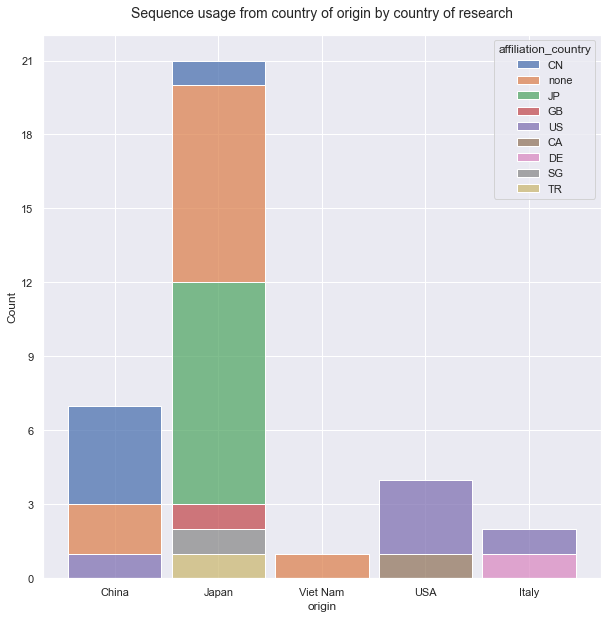

In [12]:
# which countries take sequences from where? # show with those that do not have origins

#df_vis = df.copy()
#df_vis.loc[df.pubMed != 'none', 'pubMed'] = 'available'
df_vis2 = combined_edges2[combined_edges2['origin'] != ''].replace({'affiliation_country':{'':'none'}})
#df.loc[df.pubMed != 'none', 'origins'] = 'available'
sns.set_theme(style="darkgrid")

ax = plt.figure(figsize=(10,10)).gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))


plt.title('Sequence usage from country of origin by country of research', fontsize = 14 , y=1.02)

sns.histplot(df_vis2, x="origin", hue="affiliation_country", stat="count", multiple="stack", shrink=.9)


In [125]:
# do it for shares of info flow
## print number of publications that have no affiliation whatsover --> this should indicate how much volume the information flow should have (18 in that case)
aff = combined_edges2['pubmedID'][(combined_edges2['affiliation_country'] != '') & (combined_edges2['origin'] != '')]
no_aff = combined_edges2['pubmedID'][(combined_edges2['affiliation_country'] == '') & (combined_edges2['origin'] != '')]

missing_completely = []
for x in no_aff:
    if x not in list(aff): 
        missing_completely.append(x)
missing_completely


['12647242', '24040239', '18582469', '17097766', '15808904']

In [14]:
## only work with known affiliations for simplicity
combined_edges3 = combined_edges2[(combined_edges2['origin'] != '') & (combined_edges2['affiliation_country'] != '')] 

In [15]:
## multiply those that took sequences from multiple origins (to get the flow volume right: if an all American publication uses sequences from two countries, both countries should have a volume 1 flow to the U.S.) --> later it will be divided by the number of rows, that is why that is necessary
share_ed = []
for pub in combined_edges3['pubmedID']:
    
    share_ed.append(1/len(list(set(combined_edges3['origin'][combined_edges3['pubmedID'] == str(pub)]))))

combined_edges3['share'] = share_ed
  
    
    


<ipython-input-15-e33dc7ba8425>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_edges3['share'] = share_ed


In [20]:
pd.set_option('display.max_rows', 40)
combined_edges3

,pubmedID,lens_scholarly_id,affiliation_country,origin,share
33,33401907,002-753-600-271-234,CN,China,1.0
111,16364184,009-879-343-347-637,JP,Japan,1.0
112,16364184,009-879-343-347-637,GB,Japan,1.0
122,15488950,011-146-671-776-960,JP,Japan,1.0
254,26021931,023-085-063-488-884,US,USA,1.0
279,15338081,025-433-472-471-048,JP,Japan,1.0
280,17934781,025-590-554-320-824,US,USA,1.0
281,17934781,025-590-554-320-824,CA,USA,1.0
282,20810728,025-627-667-407-324,CN,China,1.0
283,20810728,025-627-667-407-324,US,China,1.0


In [17]:
combined_edges4 = 1/combined_edges3.groupby('pubmedID').sum().rename(columns={'share':'info_flow'}) #--> take this value and devide the share of combined_edges3 with it

In [21]:
combined_edges4

,info_flow
pubmedID,
15042329,1.0
15338081,1.0
15488950,1.0
16364184,0.5
17804255,0.5
17934781,0.5
18391543,1.0
20008370,0.5
20483239,1.0


In [22]:
combined_edges5 = pd.merge(combined_edges3, combined_edges4, on = 'pubmedID', how = 'left').drop(columns=['share'])

In [23]:
combined_edges5['info_flow'].sum()

18.0

<AxesSubplot:title={'center':'Information flow from country of origin to country of research (weighted)'}, xlabel='origin', ylabel='Count'>

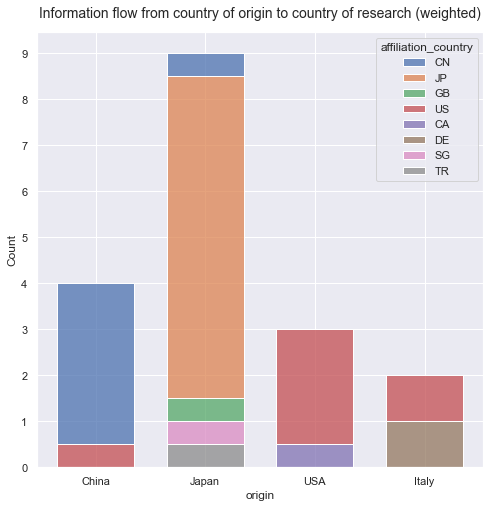

In [24]:
# which countries take sequences from where? # show with those that do not have origins

#df_vis = df.copy()
#df_vis.loc[df.pubMed != 'none', 'pubMed'] = 'available'
df_vis2 = combined_edges5[combined_edges5['origin'] != ''].replace({'affiliation_country':{'':'none'}})
#df.loc[df.pubMed != 'none', 'origins'] = 'available'

ax = plt.figure(figsize=(8,8)).gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
sns.set_theme(style="darkgrid")
plt.title('Information flow from country of origin to country of research (weighted)', fontsize = 14 , y=1.02)

sns.histplot(df_vis2, x="origin", hue="affiliation_country", weights = 'info_flow', stat="count", multiple="stack", shrink=.7)

In [27]:
## export the data files
combined_edges5.to_csv('../Network data/country_country_edges[info_flow].csv',index=False)

In [ ]:
# also show this in the form of the information flow network 

## 2. Transform publication-patent edges into country of affiliation - country of company edges

In [3]:
# open the raw publication data again so that I can edit it
with open(r'..\Raw data\full-data_patent-lens.json') as json_string:
    data2 = json.load(json_string)
    

In [4]:
#combined_edges2 = pd.read_csv('../Network data/country_country_edges[usage].csv')

In [11]:
combined_edges2

,pubmedID,lens_scholarly_id,affiliation_country,origin
0,22154646,000-088-774-471-797,NaN,NaN
1,16040253,000-110-292-610-940,JP,NaN
2,12751327,000-136-263-343-367,FR,NaN
3,21268182,000-416-374-863-927,GB,NaN
4,21268182,000-416-374-863-927,US,NaN
...,...,...,...,...
827,17873000,179-441-731-703-195,NaN,NaN
828,11533028,188-968-467-250-664,NL,NaN
829,11533028,188-968-467-250-664,NaN,NaN
830,11533028,188-968-467-250-664,DE,NaN


In [ ]:
#pp.pprint(data2)

### 2.1. Inspect the data


In [39]:
print(data2[0]['data'][0].keys())

dict_keys(['lens_id', 'jurisdiction', 'date_published', 'doc_key', 'biblio', 'publication_type'])


In [120]:
data2[0]['data'][10]['publication_type'] #this is the patent type

'SEARCH_REPORT'

In [9]:
print(data2[0]['data'][0]['doc_key']) # this is the patent number

EP_2772551_A1_20140903


In [92]:
print(data2[0]['data'][0]['biblio'].keys())

dict_keys(['invention_title', 'parties', 'references_cited', 'cited_by'])


In [5]:
print(data2[0]['data'][1]['biblio']['parties'].keys())# these keys are always different, would be interesting to know what determines what information is available --> related to the patent status?


dict_keys(['examiners', 'applicants', 'inventors', 'agents', 'owners_all'])


In [28]:
print(data2[0]['data'][1]['biblio']['parties']) 

{'examiners': {'primary_examiner': {'department': '1653', 'extracted_name': {'value': 'Patricia A Leith'}}, 'assistant_examiner': {'extracted_name': {'value': 'Erin M Bowers'}}}, 'applicants': [{'residence': 'SG', 'extracted_name': {'value': 'LIANG ZHAO-XUN'}}, {'residence': 'SG', 'extracted_name': {'value': 'RAO FENG'}}, {'residence': 'SG', 'extracted_name': {'value': 'UNIV NANYANG TECH'}}], 'inventors': [{'residence': 'SG', 'sequence': 1, 'extracted_name': {'value': 'LIANG ZHAO-XUN'}}, {'residence': 'SG', 'sequence': 2, 'extracted_name': {'value': 'RAO FENG'}}], 'agents': [{'extracted_name': {'value': 'MKG, LLC'}}], 'owners_all': [{'recorded_date': '2012-07-31', 'execution_date': '2012-07-18', 'extracted_name': {'value': 'NANYANG TECHNOLOGICAL UNIVERSITY'}, 'extracted_address': '50 NANYANG AVENUE, SINGAPORE, 639798', 'extracted_country': 'SG'}]}


In [72]:
#does that avialability of patent info depend on patent status?


for batch in data2:
    for patent in batch['data']:
        print(patent['publication_type'] + '   --> ' + str(patent['biblio']['parties'].keys()))
        
    break
    
    #data2[batch]['data'][0]['publication_type']


PATENT_APPLICATION   --> dict_keys(['applicants', 'inventors', 'agents'])
GRANTED_PATENT   --> dict_keys(['examiners', 'applicants', 'inventors', 'agents', 'owners_all'])
GRANTED_PATENT   --> dict_keys(['examiners', 'applicants', 'inventors', 'agents', 'owners_all'])
GRANTED_PATENT   --> dict_keys(['examiners', 'applicants', 'inventors', 'agents', 'owners_all'])
GRANTED_PATENT   --> dict_keys(['examiners', 'applicants', 'inventors', 'agents', 'owners_all'])
GRANTED_PATENT   --> dict_keys(['examiners', 'applicants', 'inventors', 'agents', 'owners_all'])
SEARCH_REPORT   --> dict_keys(['applicants', 'inventors', 'agents'])
GRANTED_PATENT   --> dict_keys(['examiners', 'applicants', 'inventors', 'agents'])
GRANTED_PATENT   --> dict_keys(['examiners', 'applicants', 'inventors', 'agents', 'owners_all'])
PATENT_APPLICATION   --> dict_keys(['applicants', 'inventors'])
SEARCH_REPORT   --> dict_keys(['applicants', 'agents'])
PATENT_APPLICATION   --> dict_keys(['applicants', 'inventors', 'agents']

In [100]:
print(data2[0]['data'][0]['biblio']['references_cited']['citations'][0].keys()) # sequence is the number of the publication that cited it, nplcit is the actual info 

dict_keys(['sequence', 'nplcit', 'cited_phase'])


In [106]:
print(data2[0]['data'][0]['biblio']['references_cited']['citations'][0]['nplcit']['lens_id']) # this is the lens id of the pub that got cited

047-431-386-818-411


In [109]:
print(data2[0]['data'][0]['lens_id']) # this is the patent id 

004-352-748-652-813


In [ ]:
# got to iterate over the seperate 100 entries per call; and then over the different publications that get cited by the patent

### 2.2. Create edges

In [14]:
combined_edges2

,pubmedID,lens_scholarly_id,affiliation_country,origin
0,22154646,000-088-774-471-797,,<NA>
1,16040253,000-110-292-610-940,JP,<NA>
2,12751327,000-136-263-343-367,FR,<NA>
3,21268182,000-416-374-863-927,GB,<NA>
4,21268182,000-416-374-863-927,US,<NA>
...,...,...,...,...
827,17873000,179-441-731-703-195,,<NA>
828,11533028,188-968-467-250-664,NL,<NA>
829,11533028,188-968-467-250-664,,<NA>
830,11533028,188-968-467-250-664,DE,<NA>


In [20]:
## first I need to make a decision about the three different options. 
# take the usage data, because I first want to link the patents to those publications that have a link to an origin
pub_patent_edges = combined_edges2[(combined_edges2['origin'] != '') & (combined_edges2['affiliation_country'] != '')].reset_index(drop=True) # need to drop duplicates, because multiple sequence origins don't matter anymore (but this is only the case of one publication so far)
#combined_edges3[combined_edges3.duplicated() == True]

In [21]:
pub_patent_edges

,pubmedID,lens_scholarly_id,affiliation_country,origin
0,33401907,002-753-600-271-234,CN,China
1,16364184,009-879-343-347-637,JP,Japan
2,16364184,009-879-343-347-637,GB,Japan
3,15488950,011-146-671-776-960,JP,Japan
4,26021931,023-085-063-488-884,US,USA
5,15338081,025-433-472-471-048,JP,Japan
6,17934781,025-590-554-320-824,US,USA
7,17934781,025-590-554-320-824,CA,USA
8,20810728,025-627-667-407-324,CN,China
9,20810728,025-627-667-407-324,US,China


#### 2.2.1. Merge the patent ID to the combined_edges3

In [11]:
df = pd.read_csv('../Network data/pub_patent_edges.csv')

In [12]:
# most patented research
counter = collections.Counter(df['pubmed_IDs'])
counter.most_common()

[(16381832, 327),
 (10360571, 68),
 (14765194, 60),
 (9560249, 53),
 (14623098, 46),
 (9680336, 41),
 (9293008, 40),
 (9195939, 36),
 (8522516, 32),
 (8441634, 32),
 (15590700, 26),
 (10542158, 26),
 (12893874, 20),
 (8828221, 20),
 (10430560, 20),
 (11782527, 19),
 (8872459, 18),
 (8798600, 18),
 (15976025, 18),
 (8277941, 17),
 (9006052, 17),
 (12813049, 17),
 (12711219, 14),
 (15499007, 14),
 (8406037, 14),
 (16381931, 14),
 (9341881, 13),
 (9524230, 13),
 (12917688, 12),
 (9012808, 12),
 (10835645, 11),
 (16794080, 11),
 (7685830, 10),
 (9086272, 10),
 (7828913, 10),
 (10932196, 10),
 (9348040, 9),
 (15843597, 9),
 (8702780, 9),
 (10714990, 9),
 (16785531, 9),
 (9887327, 9),
 (7878465, 8),
 (11032317, 8),
 (8177738, 8),
 (21592973, 8),
 (15496914, 8),
 (7708661, 7),
 (9295353, 7),
 (11867707, 7),
 (15965714, 7),
 (15062640, 7),
 (8226990, 7),
 (8532683, 7),
 (16484289, 7),
 (3017658, 6),
 (8626329, 6),
 (10523524, 5),
 (11387336, 5),
 (10077530, 5),
 (12032319, 5),
 (14623291, 5),


In [23]:
# add to get only that research that has CoO and is cited by a patent
pub_patent_edges2 = pd.merge(left = pub_patent_edges, right = df[['patentID','publication_ids']].rename(columns = {'publication_ids':'lens_scholarly_id'}), on=["lens_scholarly_id"], how = 'inner')

In [24]:
pub_patent_edges2

,pubmedID,lens_scholarly_id,affiliation_country,origin,patentID
0,17934781,025-590-554-320-824,US,USA,139-865-047-745-282
1,17934781,025-590-554-320-824,US,USA,010-554-005-688-295
2,17934781,025-590-554-320-824,US,USA,188-463-312-332-354
3,17934781,025-590-554-320-824,US,USA,170-300-290-625-446
4,17934781,025-590-554-320-824,CA,USA,139-865-047-745-282
5,17934781,025-590-554-320-824,CA,USA,010-554-005-688-295
6,17934781,025-590-554-320-824,CA,USA,188-463-312-332-354
7,17934781,025-590-554-320-824,CA,USA,170-300-290-625-446
8,21551351,049-685-048-514-012,JP,Japan,181-439-971-474-685
9,21551351,049-685-048-514-012,JP,Japan,024-724-547-612-25X


In [35]:
# how many countries have linkages into commerce
len(set(combined_edges4['affiliation_country'][combined_edges4['affiliation_country'] != '']))

21

In [36]:
# how many countries have linkages into commerce
len(set(combined_edges4['pubmedID'][combined_edges4['affiliation_country'] != '']))

120

In [38]:
# see the contrast to all publications (also those that do not have a CoR)
len(set(combined_edges4['pubmedID']))

157

In [ ]:
# this seems to be good. may want to consider dropping the non-countries at some point though, because now I would have links from nothing to a patent as well.. 

In [179]:
# here I can see why there are so much more... a pub gets cited multiple times by a patent, also if it only has one entry in combined_edges 3 (because of only no, or only one... country affiliation). seems right

In [206]:
# nr of actual edges: 
combined_edges5 = combined_edges4[combined_edges4['affiliation_country'].notnull()]
combined_edges5

,pubmedID,lens_scholarly_id,affiliation_country,patentID
3,16754674,001-766-225-888-078,AU,050-603-106-203-102
4,7685830,001-870-359-848-039,US,080-449-866-540-086
5,7685830,001-870-359-848-039,US,048-572-631-087-065
6,7685830,001-870-359-848-039,US,082-037-988-990-159
7,7685830,001-870-359-848-039,US,020-667-810-056-489
...,...,...,...,...
2184,9195939,155-709-883-105-593,US,069-976-222-493-946
2185,9195939,155-709-883-105-593,US,167-500-833-468-781
2186,9195939,155-709-883-105-593,US,050-272-327-454-534
2187,9195939,155-709-883-105-593,US,175-165-874-581-507


In [211]:
combined_edges5.drop_duplicates() ##??? why do I have duplicates here again? 

,pubmedID,lens_scholarly_id,affiliation_country,patentID
3,16754674,001-766-225-888-078,AU,050-603-106-203-102
4,7685830,001-870-359-848-039,US,080-449-866-540-086
5,7685830,001-870-359-848-039,US,048-572-631-087-065
6,7685830,001-870-359-848-039,US,082-037-988-990-159
7,7685830,001-870-359-848-039,US,020-667-810-056-489
...,...,...,...,...
2184,9195939,155-709-883-105-593,US,069-976-222-493-946
2185,9195939,155-709-883-105-593,US,167-500-833-468-781
2186,9195939,155-709-883-105-593,US,050-272-327-454-534
2187,9195939,155-709-883-105-593,US,175-165-874-581-507


In [210]:
combined_edges5[combined_edges5['patentID'] == '149-485-300-736-063']

,pubmedID,lens_scholarly_id,affiliation_country,patentID
33,14765194,002-921-223-837-297,DE,149-485-300-736-063
55,14765194,002-921-223-837-297,DE,149-485-300-736-063
74,14765194,002-921-223-837-297,DE,149-485-300-736-063
153,14765194,002-921-223-837-297,GB,149-485-300-736-063
175,14765194,002-921-223-837-297,GB,149-485-300-736-063
194,14765194,002-921-223-837-297,GB,149-485-300-736-063


In [154]:
counter = collections.Counter(combined_edges4['patentID'])
counter.most_common()

[('149-485-300-736-063', 9),
 ('179-946-012-931-750', 8),
 ('006-651-310-558-470', 8),
 ('116-844-306-294-870', 6),
 ('154-409-128-768-579', 6),
 ('040-117-129-479-455', 6),
 ('069-361-692-415-984', 6),
 ('043-159-681-138-085', 6),
 ('048-862-102-487-739', 6),
 ('042-886-270-772-131', 6),
 ('073-002-226-450-600', 6),
 ('010-738-425-717-52X', 6),
 ('160-695-288-177-951', 6),
 ('087-546-732-360-345', 6),
 ('025-307-712-272-551', 6),
 ('067-781-432-310-789', 6),
 ('080-614-165-439-387', 6),
 ('057-188-448-894-934', 6),
 ('000-430-780-371-54X', 6),
 ('001-865-847-769-325', 6),
 ('086-187-004-239-098', 6),
 ('162-105-332-496-205', 6),
 ('168-192-498-159-176', 6),
 ('019-754-265-252-221', 6),
 ('110-821-422-139-149', 6),
 ('063-105-791-252-876', 6),
 ('105-623-177-073-669', 6),
 ('194-559-301-790-61X', 6),
 ('123-892-920-667-294', 6),
 ('030-940-732-865-594', 6),
 ('039-574-419-848-640', 6),
 ('133-680-611-354-735', 6),
 ('098-840-481-176-266', 6),
 ('174-130-240-383-473', 6),
 ('153-875-536

In [199]:
# looking at the only developing country in here, unless we also count China, Taiwan? 
combined_edges4[combined_edges4['affiliation_country'] == 'GH']

,pubmedID,lens_scholarly_id,affiliation_country,patentID
197,16091594,002-997-731-198-63X,GH,147-596-129-823-800
198,16091594,002-997-731-198-63X,GH,196-052-132-664-523


In [17]:
len(set(combined_edges4['patentID']))

1315

In [200]:
combined_edges3[combined_edges3['pubmedID'] == '16091594']

,pubmedID,lens_scholarly_id,affiliation_country
42,16091594,002-997-731-198-63X,JP
43,16091594,002-997-731-198-63X,GH
44,16091594,002-997-731-198-63X,


#### 2.2. Map the country affiliation of patent holders onto the combined_edges4 (this should create even more links)  

In [92]:
scholarly_affiliations

['US',
 'FR',
 'DE',
 'SG',
 'US',
 'IL',
 'DE',
 'GB',
 'CA',
 'FR',
 'CH',
 'US',
 'DE',
 'US',
 'US',
 'DE',
 'US',
 'US',
 'FR',
 'CH',
 'FR',
 'GB',
 'GB',
 'DE',
 'US',
 'US',
 'DE',
 'DE',
 'GB',
 'GB',
 'US',
 'DK',
 'US',
 'US',
 'US',
 'US',
 'US',
 'SE',
 'US',
 'US',
 'JP',
 'FR',
 'US',
 'DE',
 'SE',
 'US',
 'DE',
 'US',
 'FR',
 'US',
 'DE',
 'US',
 'US',
 'CH',
 'US',
 'FR',
 'JP',
 'GB',
 'GB',
 'US',
 'US',
 'US',
 'GB',
 'CA',
 'US',
 'CA',
 'US',
 'SE',
 'FR',
 'US',
 'DK',
 'US',
 'US',
 'DE',
 'DE',
 'GB']

In [165]:

company_affiliations = []
scholarly_affiliations = []
patent_id = []

for batch in data2:
   
    for patent in batch['data']:
        
        
        if patent['lens_id'] in list(combined_edges5['patentID']): # this is to look only at those patents that actually have a science affiliation country 
            
            scholarly_id = combined_edges5['pubmedID'][combined_edges5['patentID'] == patent['lens_id']].values # need to incorporate this to make it more transparent
            
            #these are the document level connections: 
            print('*document level*: \n' + str(patent['lens_id']))
            print('... draws on: '+str(scholarly_id))
            
            
            # no go into the country level connections
            for affiliation_scholar in combined_edges5['affiliation_country'][combined_edges5['patentID'] == patent['lens_id']].values:  # choose the affilation_country of the science cited by the selected patent
                
                print('*country level*: \nScience origin: \t' + str(affiliation_scholar))
        
                affiliation_patent = ''
                if 'applicants' in patent['biblio']['parties'].keys():
                    
                        for applicant in patent['biblio']['parties']['applicants']: 
                            if 'residence' in applicant.keys():       #'residence' in patent['biblio']['parties']['applicants'][0]:
                                
                                
                                print('Applicant: \t' + str(applicant['residence']))
                                
                                
                                affiliation_patent = applicant['residence']   # I am actually always taking the last one now. But I might want to take all? Only if they are institutions? 
                                scholarly_affiliations.append(affiliation_scholar)
                                company_affiliations.append(affiliation_patent)
                                patent_id.append(patent['lens_id'])
                                
                                
                            else: 
                                print('ahahha')
                                print(patent['biblio']['parties'])
                        
                        print('\t\t')     
                            
                else: 
                    print('**EUDAAAAAA**')
                
    
        
                
    
        
        
        ## this is if looking into owners as well: 
        #if 'owners_all' in list(patent['biblio']['parties'].keys()):
        #    for applicant in patent['biblio']['parties']['residence']: 
        #        print('Applicant: \t' + str(applicant))
        #    for owners in patent['biblio']['parties']['owners_all']:
        #        print(owners)
                
                #if 'extracted_country' in owners.keys(): 
                #    print('Owners: \t' + str(owners['extracted_country']))
                #else: 
                #    print(owners)
        #   print('\t\t')
        
 
    
    #data2[batch]['data'][0]['publication_type']
    
    

# export it as dictionary
science_orig_to_patent_orig = {'science_origin': scholarly_affiliations, 'patent_origin': company_affiliations, 'patent_id' : patent_id}  
df_science_orig_to_patent_orig = pd.DataFrame(science_orig_to_patent_orig)


*document level*: 
006-708-787-692-460
... draws on: [10360571]
*country level*: 
Science origin: 	US
Applicant: 	SG
Applicant: 	SG
Applicant: 	SG
		
*document level*: 
007-168-527-298-573
... draws on: [10835645]
*country level*: 
Science origin: 	FR
Applicant: 	US
		
*document level*: 
007-699-611-305-441
... draws on: [8406037]
*country level*: 
Science origin: 	DE
Applicant: 	US
		
*document level*: 
008-211-544-983-713
... draws on: [11867707]
*country level*: 
Science origin: 	SG
Applicant: 	US
		
*document level*: 
008-384-535-822-825
... draws on: [10360571]
*country level*: 
Science origin: 	US
Applicant: 	US
		
*document level*: 
009-747-089-886-357
... draws on: [22689988]
*country level*: 
Science origin: 	IL
Applicant: 	IL
Applicant: 	IL
Applicant: 	IL
		
*document level*: 
020-512-339-579-635
... draws on: [1628664]
*country level*: 
Science origin: 	DE
ahahha
{'applicants': [{'extracted_name': {'value': 'EZAKI GLICO CO'}}], 'agents': [{'extracted_name': {'value': 'UEXKÜL

{'applicants': [{'extracted_name': {'value': 'WELSH MICHAEL J'}}, {'extracted_name': {'value': 'ROGERS CHRISTOPHER S'}}, {'extracted_name': {'value': 'PRATHER RANDALL'}}, {'extracted_name': {'value': 'ENGELHARDT JOHN'}}, {'extracted_name': {'value': 'YAN ZIYING'}}], 'inventors': [{'residence': 'US', 'sequence': 1, 'extracted_name': {'value': 'WELSH MICHAEL J'}}, {'residence': 'US', 'sequence': 2, 'extracted_name': {'value': 'ROGERS CHRISTOPHER S'}}, {'residence': 'US', 'sequence': 3, 'extracted_name': {'value': 'PRATHER RANDALL'}}, {'residence': 'US', 'sequence': 4, 'extracted_name': {'value': 'ENGELHARDT JOHN'}}, {'residence': 'US', 'sequence': 5, 'extracted_name': {'value': 'YAN ZIYING'}}], 'owners_all': [{'recorded_date': '2010-03-08', 'execution_date': '2009-12-19', 'extracted_name': {'value': 'UNIVERSITY OF IOWA RESEARCH FOUNDATION'}, 'extracted_address': 'IOWA CENTERS FOR ENTERPRISE, 2660 UNIVERSITY CAPITOL CENTRE, 200 SOUTH CAPITOL STREET, IOWA CITY, IOWA, 52242-5500'}, {'record

031-085-669-304-197
... draws on: [16484289]
*country level*: 
Science origin: 	JP
Applicant: 	US
		
*document level*: 
032-238-125-868-315
... draws on: [8626329]
*country level*: 
Science origin: 	US
Applicant: 	US
		
*document level*: 
034-064-100-374-568
... draws on: [16785531 16785531]
*country level*: 
Science origin: 	GB
Applicant: 	NL
Applicant: 	NL
		
*country level*: 
Science origin: 	US
Applicant: 	NL
Applicant: 	NL
		
*document level*: 
034-243-008-333-484
... draws on: [14765194 14765194]
*country level*: 
Science origin: 	DE
Applicant: 	US
		
*country level*: 
Science origin: 	GB
Applicant: 	US
		
*document level*: 
034-629-923-945-785
... draws on: [10835645]
*country level*: 
Science origin: 	FR
Applicant: 	CA
		
*document level*: 
036-168-682-997-325
... draws on: [10077531]
*country level*: 
Science origin: 	US
Applicant: 	CN
		
*document level*: 
039-574-419-848-640
... draws on: [ 9012808  9012808  9524230 10430560]
*country level*: 
Science origin: 	FR
Applicant: 

110-821-422-139-149
... draws on: [15499007 15499007 15499007 15499007 15499007]
*country level*: 
Science origin: 	US
Applicant: 	US
		
*country level*: 
Science origin: 	BE
Applicant: 	US
		
*country level*: 
Science origin: 	GB
Applicant: 	US
		
*country level*: 
Science origin: 	CA
Applicant: 	US
		
*country level*: 
Science origin: 	CH
Applicant: 	US
		
*document level*: 
112-626-574-182-84X
... draws on: [14765194 14765194]
*country level*: 
Science origin: 	DE
Applicant: 	JP
		
*country level*: 
Science origin: 	GB
Applicant: 	JP
		
*document level*: 
119-106-050-583-082
... draws on: [9560249 9560249]
*country level*: 
Science origin: 	US
Applicant: 	US
		
*country level*: 
Science origin: 	US
Applicant: 	US
		
*document level*: 
122-191-271-458-370
... draws on: [12813049]
*country level*: 
Science origin: 	CH
Applicant: 	FR
Applicant: 	FR
Applicant: 	FR
Applicant: 	FR
Applicant: 	FR
Applicant: 	FR
Applicant: 	FR
		
*document level*: 
122-582-445-193-295
... draws on: [1584359

013-327-816-265-607
... draws on: [9680336]
*country level*: 
Science origin: 	FR
Applicant: 	US
		
*document level*: 
013-651-460-248-463
... draws on: [9293008 9195939 9195939]
*country level*: 
Science origin: 	US
Applicant: 	US
		
*country level*: 
Science origin: 	DK
Applicant: 	US
		
*country level*: 
Science origin: 	US
Applicant: 	US
		
*document level*: 
020-013-136-922-572
... draws on: [3017658]
*country level*: 
Science origin: 	US
Applicant: 	FI
		
*document level*: 
020-140-552-261-189
... draws on: [10360571]
*country level*: 
Science origin: 	US
Applicant: 	US
Applicant: 	US
Applicant: 	US
Applicant: 	US
Applicant: 	US
		
*document level*: 
023-588-548-498-882
... draws on: [15496914 15496914 15496914]
*country level*: 
Science origin: 	FR
Applicant: 	JP
Applicant: 	JP
Applicant: 	JP
Applicant: 	JP
		
*country level*: 
Science origin: 	US
Applicant: 	JP
Applicant: 	JP
Applicant: 	JP
Applicant: 	JP
		
*country level*: 
Science origin: 	DE
Applicant: 	JP
Applicant: 	JP
Ap

*country level*: 
Science origin: 	US
Applicant: 	US
		
*country level*: 
Science origin: 	US
Applicant: 	US
		
*document level*: 
136-072-548-202-818
... draws on: [10360571]
*country level*: 
Science origin: 	US
Applicant: 	JP
Applicant: 	JP
Applicant: 	JP
Applicant: 	JP
Applicant: 	JP
Applicant: 	JP
Applicant: 	JP
Applicant: 	JP
Applicant: 	JP
Applicant: 	JP
		
*document level*: 
137-685-395-655-864
... draws on: [12917688]
*country level*: 
Science origin: 	US
Applicant: 	US
Applicant: 	US
Applicant: 	US
Applicant: 	US
Applicant: 	US
Applicant: 	US
Applicant: 	US
		
*document level*: 
138-435-253-631-300
... draws on: [14623098]
*country level*: 
Science origin: 	SE
Applicant: 	US
Applicant: 	US
Applicant: 	US
Applicant: 	US
Applicant: 	US
		
*document level*: 
139-366-468-334-274
... draws on: [11867707]
*country level*: 
Science origin: 	SG
Applicant: 	US
		
*document level*: 
146-996-341-809-64X
... draws on: [12435500]
*country level*: 
Science origin: 	JP
Applicant: 	US
		
*do

In [168]:
combined_edges5[(combined_edges5['pubmedID'] == 14765194) & (combined_edges5['patentID'] == '069-361-692-415-984')]

,pubmedID,lens_scholarly_id,affiliation_country,patentID
21,14765194,002-921-223-837-297,DE,069-361-692-415-984
43,14765194,002-921-223-837-297,DE,069-361-692-415-984
141,14765194,002-921-223-837-297,GB,069-361-692-415-984
163,14765194,002-921-223-837-297,GB,069-361-692-415-984


In [147]:
combined_edges5

,pubmedID,lens_scholarly_id,affiliation_country,patentID
3,16754674,001-766-225-888-078,AU,050-603-106-203-102
4,7685830,001-870-359-848-039,US,080-449-866-540-086
5,7685830,001-870-359-848-039,US,048-572-631-087-065
6,7685830,001-870-359-848-039,US,082-037-988-990-159
7,7685830,001-870-359-848-039,US,020-667-810-056-489
...,...,...,...,...
2184,9195939,155-709-883-105-593,US,069-976-222-493-946
2185,9195939,155-709-883-105-593,US,167-500-833-468-781
2186,9195939,155-709-883-105-593,US,050-272-327-454-534
2187,9195939,155-709-883-105-593,US,175-165-874-581-507


In [125]:
df_science_orig_to_patent_orig_nodub = df_science_orig_to_patent_orig.drop_duplicates()

In [133]:
df_science_orig_to_patent_orig

,science_origin,patent_origin,patent_id
0,US,SG,006-708-787-692-460
1,US,SG,006-708-787-692-460
2,US,SG,006-708-787-692-460
3,FR,US,007-168-527-298-573
4,DE,US,007-699-611-305-441
...,...,...,...
2470,JP,JP,189-696-296-473-942
2471,JP,JP,189-696-296-473-942
2472,JP,JP,189-696-296-473-942
2473,DE,KR,196-694-704-964-80X


In [134]:
counter = collections.Counter(df_science_orig_to_patent_orig['patent_id'])
counter.most_common()

[('188-996-606-245-557', 33),
 ('053-921-674-254-680', 32),
 ('169-703-926-460-001', 30),
 ('098-840-481-176-266', 28),
 ('194-559-301-790-61X', 28),
 ('018-928-322-742-456', 28),
 ('016-561-036-191-074', 27),
 ('019-754-265-252-221', 25),
 ('087-546-732-360-345', 25),
 ('168-192-498-159-176', 25),
 ('070-131-636-782-386', 20),
 ('119-868-125-378-288', 16),
 ('116-844-306-294-870', 16),
 ('073-002-226-450-600', 16),
 ('133-712-564-488-557', 15),
 ('158-251-416-726-902', 15),
 ('189-672-045-094-829', 15),
 ('016-933-130-846-879', 14),
 ('133-156-829-841-068', 14),
 ('159-979-650-732-022', 14),
 ('077-894-923-060-431', 14),
 ('196-310-198-709-674', 14),
 ('154-409-128-768-579', 12),
 ('016-964-904-603-021', 12),
 ('142-722-445-201-512', 12),
 ('091-236-323-460-098', 12),
 ('088-405-184-823-931', 12),
 ('043-159-681-138-085', 12),
 ('023-588-548-498-882', 12),
 ('075-985-341-066-156', 12),
 ('196-383-385-458-011', 12),
 ('019-111-793-823-228', 10),
 ('106-604-806-272-832', 10),
 ('164-680

In [136]:
df_science_orig_to_patent_orig[df_science_orig_to_patent_orig['patent_id'] == '188-996-606-245-557']

,science_origin,patent_origin,patent_id
1814,US,US,188-996-606-245-557
1815,US,US,188-996-606-245-557
1816,US,US,188-996-606-245-557
1817,US,US,188-996-606-245-557
1818,US,US,188-996-606-245-557
1819,US,US,188-996-606-245-557
1820,US,GB,188-996-606-245-557
1821,US,US,188-996-606-245-557
1822,US,US,188-996-606-245-557
1823,US,US,188-996-606-245-557


In [ ]:
# but some patents draw on various publications, so why aren't there patents with more links to them? this seems to be a flaw
# I cannot just drop dubplicates, because there shoudl be edges with weights. however, what about edges from other countries?
# have to incorporate the lens_scholarly_id to make it possible to check what I am doing (and then I can drop the duplicates)
# maybe it makes sense to take this step-by-step and just append a list of patent affiliation countries to the already existing edges, and then create new edges per patent affiliation in the list
# and I should probably define a few example to check on each step whether it is correct

In [132]:
combined_edges5[combined_edges5['patentID'] == '196-310-198-709-674']

,pubmedID,lens_scholarly_id,affiliation_country,patentID
71,14765194,002-921-223-837-297,DE,196-310-198-709-674
191,14765194,002-921-223-837-297,GB,196-310-198-709-674


In [29]:
combined_edges4

,pubmedID,lens_scholarly_id,affiliation_country,patentID
0,9293009,001-612-316-391-591,NaN,116-844-306-294-870
1,11423994,001-765-757-045-499,NaN,080-623-683-582-559
2,16754674,001-766-225-888-078,NaN,050-603-106-203-102
3,16754674,001-766-225-888-078,AU,050-603-106-203-102
4,7685830,001-870-359-848-039,US,080-449-866-540-086
...,...,...,...,...
2237,16381931,189-417-293-488-28X,NaN,004-632-202-009-785
2238,16381931,189-417-293-488-28X,NaN,017-730-172-946-292
2239,16381931,189-417-293-488-28X,NaN,089-304-766-624-071
2240,16381931,189-417-293-488-28X,NaN,029-779-142-383-006


In [99]:
combined_edges5[combined_edges5['patentID'] == '006-708-787-692-460']

,pubmedID,lens_scholarly_id,affiliation_country,patentID
263,10360571,007-462-642-839-782,US,006-708-787-692-460


In [24]:
type(s)

pandas.core.series.Series

In [52]:
combined_edges4.loc[[1011]]

,pubmedID,lens_scholarly_id,affiliation_country,patentID
1011,16381832,028-580-107-270-044,NaN,004-352-748-652-813


In [53]:
combined_edges4.loc[[1698]]

,pubmedID,lens_scholarly_id,affiliation_country,patentID
1698,8406037,060-897-487-586-977,NaN,001-770-161-687-382


In [20]:
company_affiliations[3]

'US'

In [66]:
len(company_affiliations)

1315

In [15]:
counter = collections.Counter(company_affiliations)
counter.most_common()

[('US', 811),
 ('JP', 101),
 ('DE', 83),
 ('', 43),
 ('CH', 32),
 ('FR', 26),
 ('CA', 24),
 ('NL', 22),
 ('IL', 19),
 ('GB', 19),
 ('DK', 17),
 ('BE', 16),
 ('AU', 14),
 ('SG', 13),
 ('KR', 10),
 ('IT', 9),
 ('CN', 9),
 ('ES', 8),
 ('AT', 6),
 ('IE', 5),
 ('KY', 3),
 ('LU', 3),
 ('HU', 3),
 ('FI', 3),
 ('SE', 3),
 ('TW', 2),
 ('BM', 2),
 ('NO', 2),
 ('CU', 2),
 ('LT', 2),
 ('IN', 1),
 ('ZA', 1),
 ('AN', 1)]

## 3. Create the country-country-country network for only those publications that connect both origins and companies

In [ ]:
## this is what I did in the other notebook
df_match = pd.read_csv(r'C:\Users\pauld\Documents\GitHub\Genetic sequence flows\Data\Genetic sequence data\Edges_country-pub_withANs67.csv', dtype = str) #.replace("'",'"', regex=True)


df_match['pubMed']

matches = []
for i in df_match['pubMed']:
    if i in pubmed_unique_for_dict:
        matches.append(i)

unique_matches = list(set(matches))

len(unique_matches) # there are 15!